In [1]:
# This model was made using a docker image
# Docker image can be found at https://hub.docker.com/r/blackboxradiology/tf-2.6_with_pytorch
# docker pull blackboxradiology/tf-2.6_with_pytorch

# python version 3.6.9
# mayplotlib version 3.3.4
# numpy version 1.19.5
# pandas version 1.1.5
# PIL version 8.2.0
# sklearn version 0.24.2
# tensorflow version 2.6.0

from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import random as python_random
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# pip install image-classifiers==1.0.0b1
from classification_models.tfkeras import Classifiers

In [2]:
np.random.seed(2021)
python_random.seed(2021)
tf.random.set_seed(2021)

mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [4]:
demo_df = pd.DataFrame(pd.read_excel("CHEXPERT DEMO.xlsx", engine='openpyxl')) #pip install openpyxl
data_df = pd.read_csv('chexpert_train.csv')

In [5]:
demo_df[:0]

,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY


In [6]:
data_df[:0]

,Path,Sex,Age,FrontalLateral,Position,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices


In [7]:
print("Number of images: " + str(len(data_df)))

Number of images: 223414


In [8]:
print("Number of patients: " + str(len(demo_df)))

Number of patients: 65401


In [9]:
split =  data_df.Path.str.split("/", expand = True)
data_df["patient_id"] = split[2]
demo_df = demo_df.rename(columns={'PATIENT': 'patient_id'})
combine_df = data_df.merge(demo_df, on="patient_id")

In [10]:
combine_df.PRIMARY_RACE.value_counts()

White                                        102402
Other                                         28095
White, non-Hispanic                           22154
Asian                                         20434
Unknown                                       15186
Black or African American                      9909
Race and Ethnicity Unknown                     8716
Other, Hispanic                                3621
Native Hawaiian or Other Pacific Islander      2809
Asian, non-Hispanic                            2793
Black, non-Hispanic                            2000
White, Hispanic                                 922
Other, non-Hispanic                             566
American Indian or Alaska Native                457
Patient Refused                                 405
Pacific Islander, non-Hispanic                  337
Native American, non-Hispanic                    55
Black, Hispanic                                  52
Asian, Hispanic                                  37
Native Ameri

In [11]:
combine_df.insert(3, "race", "")

In [12]:
mask = (combine_df.PRIMARY_RACE.str.contains("Black", na=False))
combine_df.loc[mask, "race"] = "BLACK/AFRICAN AMERICAN"

mask = (combine_df.PRIMARY_RACE.str.contains("White", na=False))
combine_df.loc[mask, "race"] = "WHITE"

mask = (combine_df.PRIMARY_RACE.str.contains("Asian", na=False))
combine_df.loc[mask, "race"] = "ASIAN"

In [13]:
#remove all labels that are not asian, black or white
combine_df = combine_df[combine_df.race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]

In [14]:
combine_df.ETHNICITY.value_counts()

Non-Hispanic/Non-Latino    149268
Unknown                      6546
Hispanic/Latino              4726
Patient Refused               160
Not Hispanic                   15
Hispanic                        1
Name: ETHNICITY, dtype: int64

In [15]:
#keep only non-hispanic labels
combine_df = combine_df[combine_df.ETHNICITY.isin(["Non-Hispanic/Non-Latino","Not Hispanic"])]

In [16]:
#frontal images only (AP/PA)
combine_df = combine_df[combine_df["FrontalLateral"]=="Frontal"]

In [17]:
print("Total images after inclusion/exclusion criteria: " + str(len(combine_df)))

Total images after inclusion/exclusion criteria: 127130


In [18]:
print("Total patients after inclusion/exclusion criteria: " + str(combine_df.patient_id.nunique()))

Total patients after inclusion/exclusion criteria: 64540


In [19]:
data_df = combine_df
data_df.insert(5, "split","none", True)
unique_sub_id = data_df.patient_id.unique()

train_percent, valid_percent, test_percent = 0.60, 0.10, 0.30

unique_sub_id = shuffle(unique_sub_id)
value1 = (round(len(unique_sub_id)*train_percent))
value2 = (round(len(unique_sub_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_sub_id)*test_percent))

In [20]:
print("Patients in training set: " + str(value1))

Patients in training set: 25730


In [21]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 4288


In [22]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 12865


In [23]:
data_df = shuffle(data_df)

train_sub_id = unique_sub_id[:value1]
validate_sub_id = unique_sub_id[value1:value3]
test_sub_id = unique_sub_id[value3:]

In [24]:
data_df.loc[data_df.patient_id.isin(train_sub_id), "split"]="train"
data_df.loc[data_df.patient_id.isin(validate_sub_id), "split"]="validate"
data_df.loc[data_df.patient_id.isin(test_sub_id), "split"]="test"

In [25]:
data_df.split.value_counts(normalize=True)

train       0.599481
test        0.300818
validate    0.099701
Name: split, dtype: float64

In [26]:
data_df.race.value_counts()

WHITE                     99037
ASIAN                     18830
BLACK/AFRICAN AMERICAN     9263
Name: race, dtype: int64

In [27]:
data_df.race.value_counts(normalize=True)

WHITE                     0.779021
ASIAN                     0.148116
BLACK/AFRICAN AMERICAN    0.072862
Name: race, dtype: float64

In [28]:
#clean up
data_df = data_df.sort_values(by=['Path'])
data_df = data_df.reset_index()
data_df = data_df.drop(columns=['index'])


In [29]:
data_df = data_df[data_df.Position.isin(['AP','PA'])]

In [30]:
train_df = data_df[data_df.split=="train"]
validation_df = data_df[data_df.split=="validate"]
test_df = data_df[data_df.split=="test"]

In [31]:
#False indicates no patient_id shared between groups

unique_train_id = train_df.patient_id.unique()
unique_validation_id = validation_df.patient_id.unique()
unique_test_id = test_df.patient_id.unique()
all_id = np.concatenate((unique_train_id, unique_validation_id, unique_test_id), axis=None)

def contains_duplicates(X):
    return len(np.unique(X)) != len(X)

contains_duplicates(all_id)

False

In [32]:
HEIGHT, WIDTH = 320, 320

arc_name = "CHEXPERT-" + str(HEIGHT) + "x" + str(WIDTH) + "_60-10-30-split-resnet34-Float16_3-race_detection"

In [33]:
resnet34, preprocess_input = Classifiers.get('resnet34')

In [34]:
with mirrored_strategy.scope():
    input_a = Input(shape=(HEIGHT, WIDTH, 3))
    base_model = resnet34(input_tensor=input_a, include_top=False, input_shape=(HEIGHT,WIDTH,3), weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(3, name='dense_logits')(x)
    output = Activation('softmax', dtype='float32', name='predictions')(x)
    model = Model(inputs=[input_a], outputs=[output])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [35]:
learning_rate = 1e-3
momentum_val=0.9
decay_val= 0.0
train_batch_size = 256 # may need to reduce batch size if OOM error occurs
test_batch_size = 256

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2, min_lr=1e-5, verbose=1)

adam_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay_val)
adam_opt = tf.keras.mixed_precision.LossScaleOptimizer(adam_opt)

with mirrored_strategy.scope():
    model.compile(optimizer=adam_opt,
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=[
                        tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
                        tf.keras.metrics.AUC(curve='PR', name='PR-AUC')
                    ],
    )

In [36]:
train_gen = ImageDataGenerator(
            rotation_range=15,
            fill_mode='constant',
            horizontal_flip=True,
            zoom_range=0.1,
            preprocessing_function=preprocess_input
            )

validate_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [37]:
train_batches = train_gen.flow_from_dataframe(train_df, directory="/tf/notebooks/SSD_data/chexpert_directory/", x_col="Path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=True,seed=2021,batch_size=train_batch_size, dtype='float32')
validate_batches = validate_gen.flow_from_dataframe(validation_df, directory="/tf/notebooks/SSD_data/chexpert_directory/", x_col="Path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=False,batch_size=test_batch_size, dtype='float32')        

Found 76205 validated image filenames belonging to 3 classes.
Found 12673 validated image filenames belonging to 3 classes.


In [38]:
train_epoch = math.ceil(len(train_df) / train_batch_size)
val_epoch = math.ceil(len(validation_df) / test_batch_size)

In [39]:
var_date = datetime.now().strftime("%Y%m%d-%H%M%S")
ES = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)
checkloss = ModelCheckpoint("../saved_models/racial_bias/trials/" + str(arc_name) + "_CXR_LR-" + str(learning_rate) + "_" + var_date+"_epoch:{epoch:03d}_val_loss:{val_loss:.5f}.hdf5", monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [40]:
model.fit(train_batches,
            validation_data=validate_batches,
            epochs=100,
            steps_per_epoch=int(train_epoch),
            validation_steps=int(val_epoch),
            workers=32,
            max_queue_size=50,
            shuffle=False,
            callbacks=[checkloss, reduce_lr, ES]
           )

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
298/298 [==============================] - 551s 2s/step - loss: 0.4800 - ROC-AUC: 0.9374 - PR-AUC: 0.8913 - val_loss: 0.8220 - val_ROC-AUC: 0.9188 - val_PR-AUC: 0.8732

Epoch 00001: val_loss improved from inf to 0.82205, saving model to ../saved_models/racial_bias/trials/CHEXPERT-320x320_60-10-30-split-resnet34-Float16_3-race_detection_CXR_LR-0.001_20210818-211230_epoch:001_val_loss:0.82205.hdf5


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
298/298 [==============================] - 492s 2s/step - loss: 0.3307 - ROC-AUC: 0.9695 - PR-AUC: 0.9454 - val_loss: 0.4644 - val_ROC-AUC: 0.9483 - val_PR-AUC: 0.9092

Epoch 00002: val_loss improved from 0.82205 to 0.46438, saving model to ../saved_models/racial_bias/trials/CHEXPERT-320x320_60-10-30-split-resnet34-Float16_3-race_detection_CXR_LR-0.001_20210818-211230_epoch:002_val_loss:0.46438.hdf5
Epoch 3/100
298/298 [==============================] - 494s 2s/step - loss: 0.2830 - ROC-AUC: 0.9772 - PR-AUC: 0.9589 - val_loss: 0.4079 - val_ROC-AUC: 0.9624 - val_PR-AUC: 0.9354

Epoch 00003: val_loss improved from 0.46438 to 0.40790, saving model to ../saved_models/racial_bias/trials/CHEXPERT-320x320_60-10-30-split-resnet34-Float16_3-race_detection_CXR_LR-0.001_20210818-211230_epoch:003_val_loss:0.40790.hdf5
Epoch 4/100
298/298 [==============================] - 495s 2s/step - loss: 0.2545 - ROC-AUC: 0.9812 - PR-AUC: 0.9656 - val_loss: 0.3118 - val_ROC-AUC: 0.9755 - val_PR-AU

In [41]:
test_batches = validate_gen.flow_from_dataframe(test_df, directory="/tf/notebooks/fishtank/radiology_datasets/CheXpert_Xray_dataset/resize_chexpert_320x320/chexpert_data/", x_col="Path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=False,batch_size=test_batch_size, dtype='float32')        

Found 38240 validated image filenames belonging to 3 classes.


In [42]:
with mirrored_strategy.scope():

    multilabel_predict_test = model.predict(test_batches, max_queue_size=10, verbose=1, steps=math.ceil(len(test_df)/test_batch_size), workers=16)


150/150 [==============================] - 98s 629ms/step


In [43]:
input_prediction = multilabel_predict_test
input_df = test_df
input_prediction_df = pd.DataFrame(input_prediction)
true_logits = pd.DataFrame()
loss_log = pd.DataFrame()

In [44]:
def stat_calc(input_prediction_df, input_df):
    ground_truth = input_df.race
    pathology_array=[
        'ASIAN',
        'BLACK/AFRICAN AMERICAN',
        'WHITE'
        ]
    i=0
    auc_array = []
    for pathology in pathology_array:
    
        new_truth = (ground_truth.str.contains(pathology)).apply(int)
        input_prediction_val = input_prediction_df[i]
        val = input_prediction_val
        AUC = roc_auc_score(new_truth, val)
        true_logits.insert(i, i, new_truth, True)
        auc_array.append(AUC)
        i += 1
        
    progress_df = pd.DataFrame({'Study':pathology_array, 'AUC':auc_array})
    print(progress_df)

In [45]:
stat_calc(input_prediction_df, input_df)

                    Study       AUC
0                   ASIAN  0.975544
1  BLACK/AFRICAN AMERICAN  0.980552
2                   WHITE  0.973676


In [47]:
import os
import sys
import glob
#import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm, trange
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

Classwise ROC AUC 

Class - Asian ROC-AUC- 0.98
Class - Black ROC-AUC- 0.98
Class - White ROC-AUC- 0.97
              precision    recall  f1-score   support

       Asian       0.87      0.82      0.85      5650
       Black       0.89      0.75      0.81      2746
       White       0.95      0.97      0.96     29844

    accuracy                           0.94     38240
   macro avg       0.90      0.85      0.87     38240
weighted avg       0.93      0.94      0.93     38240



<AxesSubplot:>

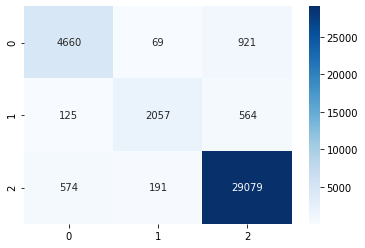

In [48]:
result = multilabel_predict_test
#result = model.predict(validate_batches, val_epoch)
labels = np.argmax(result, axis=1)
target_names = ['Asian', 'Black', 'White']

print ('Classwise ROC AUC \n')
for p in list(set(labels)):
    fpr, tpr, thresholds = roc_curve(test_batches.classes, result[:,p], pos_label = p)
    auroc = round(auc(fpr, tpr), 2)
    print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))

print (classification_report(test_batches.classes, labels, target_names=target_names))
class_matrix = confusion_matrix(test_batches.classes, labels)

sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')